# Part 3

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import math 
from tensorflow.keras.layers import Input, Embedding, dot, Dot, add,Flatten, concatenate, Concatenate,Dropout, Dense, BatchNormalization, add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import gc; gc.enable()
from sklearn import preprocessing, metrics
from sklearn.metrics import mean_squared_error
encoder = preprocessing.LabelEncoder()
from tensorflow.keras.callbacks import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
import timeit
path = '/content/drive/MyDrive/Ass2_data/'

In [3]:
def reduce_mem_usage(df):
  start_mem=df.memory_usage().sum() / 1024**2

  for col in tqdm(df.columns) :
    col_type=df[col].dtype
    if col_type != object and col_type.name!='category' and 'datetime' not in col_type.name:
      c_min= df[col].min()
      c_max= df[col].max()
      if str(col_type)[:3] == 'int':

        if c_min> np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          df[col]=df[col].astype(np.int8)
        elif c_min> np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col]=df[col].astype(np.int16)
        elif c_min> np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col]=df[col].astype(np.int32)
        elif c_min> np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          df[col]=df[col].astype(np.int64)
        
      else:
        if c_min> np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
          df[col]=df[col].astype(np.float16)
        elif c_min> np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          df[col]=df[col].astype(np.float32)
        else:
          df[col]=df[col].astype(np.float64)
      
    elif 'datatime' not in col_type.name:
      df[col]= df[col].astype('category')
    
  end_mem=df.memory_usage().sum()/1024**2
  return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

## a. Group name

In [ ]:
'''   BGU-DL Happy tree friends   '''

## b. Form a solid benchmark, Use classical ML algorithm

Data preperation :
read data, fill NA, normalize, analize, create features

To predict the target "unit sales" of the test dataset, 
we decided to create store, item and dates features

Data reading

In [4]:
dtypes_dict = {'id':'int64', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion':'float16'}

In [5]:
train_data = pd.read_csv(path + 'train.csv', parse_dates=['date'], dtype=dtypes_dict)
train_data['year'] = train_data['date'].dt.year

Filter data beacause of memory problem
we choose to filter the data to year=2017


In [6]:
train_data = train_data.query('year == 2017')

Fill NA values

In [7]:
def find_nan_values(df):
    if df.isnull().values.any():
        null_columns=df.columns[df.isnull().any()].tolist()
        for column in null_columns:
            total_values=df.shape[0]
            null_values=df[column].isnull().sum()
            print("No of Nan values in '{}' column --> {}".format(column,null_values))
            print("{:.2f} % of total values".format(100*null_values / total_values))
            print("\n")
    else:
            print("no nan values...")
find_nan_values(train_data)
train_data['onpromotion'] = train_data['onpromotion'].fillna(np.int(0))

no nan values...


Normalize target feature with log

In [8]:
def log1p_normalization(col):
  list=[]
  for value in tqdm(col):
    if float(value) > 0:
      value=np.log2(float(value)+1)
    else:
      value=0
    list.append(value)
  return list

In [9]:
train_data['unit_sales']=log1p_normalization(train_data['unit_sales'])

100%|██████████| 23808261/23808261 [00:37<00:00, 632885.38it/s]


analizing data:
we display plots to understand the distribution of our features
in this stage, we are analizing the basic features( store, item and date features)

---



In [10]:
def plot_bar_plot(df, y_col="unit_sales",title ='title', x_label='x_label', y_label='y_label'):
  fig, ax = plt.subplots()
  fig.set_size_inches(15,8)
  ax= sns.barplot(x = df.index, y =y_col, data = df)
  plt.title(title, fontsize=15)
  plt.ylabel(y_label)
  plt.xlabel(x_label)
  plt.show()

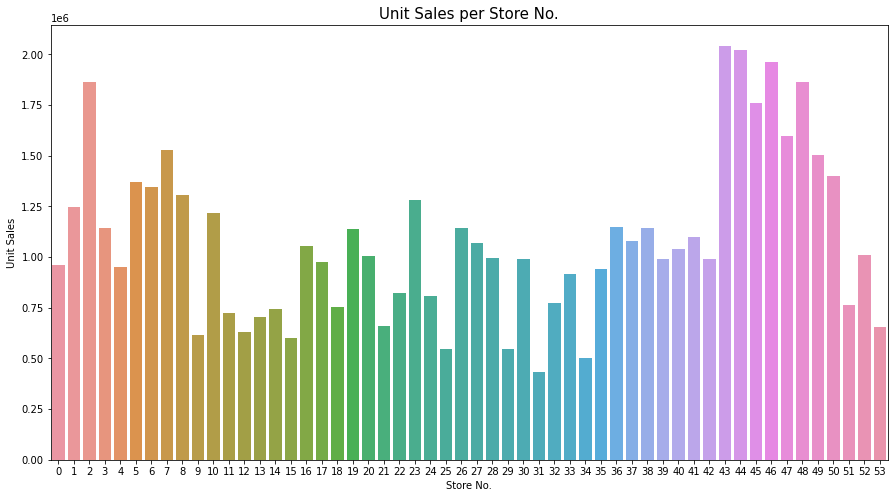

In [11]:
x = train_data.groupby(['store_nbr'], as_index = False).agg({'unit_sales':'sum'})
plot_bar_plot(x,title='Unit Sales per Store No.', x_label='Store No.', y_label='Unit Sales')

In [12]:
train_data['month'] = train_data['date'].dt.month

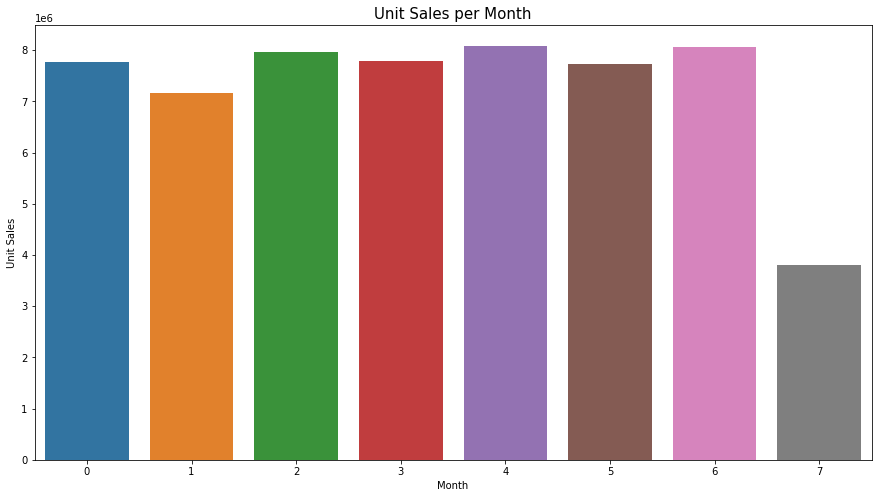

In [13]:
x = train_data.groupby(["month"], as_index=False).agg({'unit_sales':'sum'})
plot_bar_plot(x,title='Unit Sales per Month', x_label='Month', y_label='Unit Sales')

In [14]:
train_data['day_of_month'] = train_data['date'].dt.day

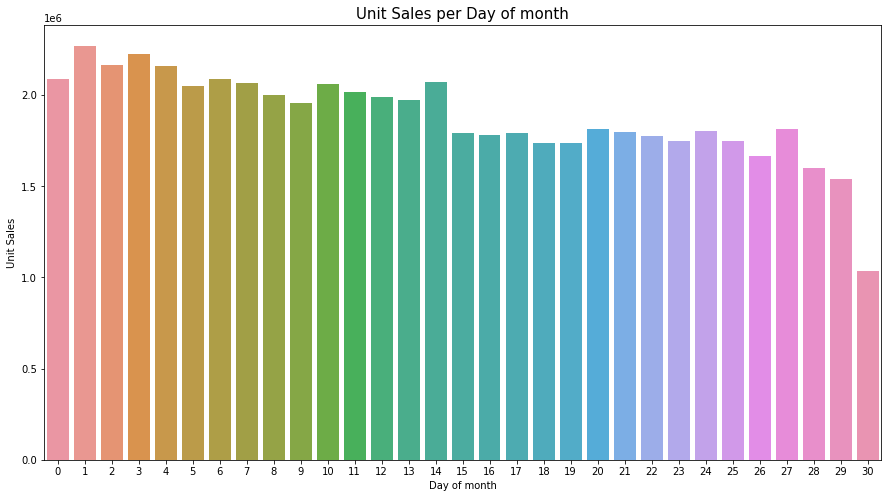

In [15]:
x = train_data.groupby(["day_of_month"], as_index=False).agg({'unit_sales':'sum'})
plot_bar_plot(x,title='Unit Sales per Day of month', x_label='Day of month', y_label='Unit Sales')

In [16]:
train_data['day_of_week'] = train_data['date'].dt.dayofweek

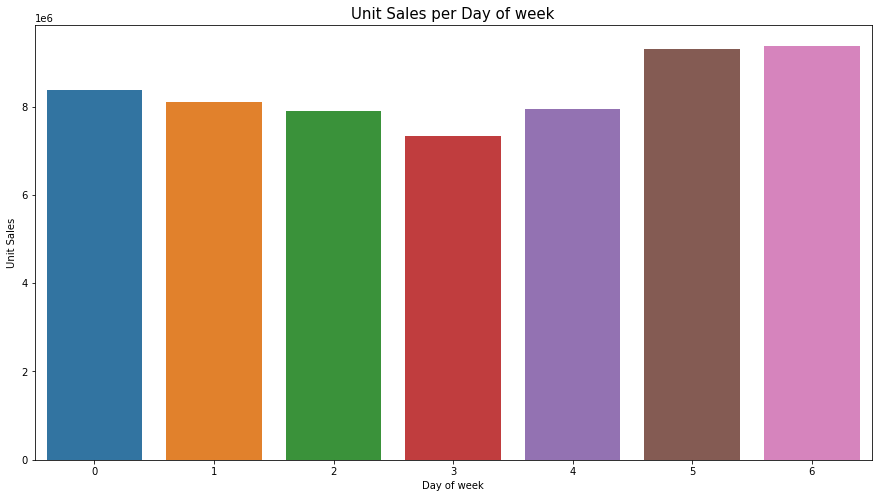

In [17]:
x = train_data.groupby(["day_of_week"], as_index=False).agg({'unit_sales':'sum'})
plot_bar_plot(x,title='Unit Sales per Day of week', x_label='Day of week', y_label='Unit Sales')

In [18]:
train_data = reduce_mem_usage(train_data)
store_data = pd.read_csv(path + 'stores.csv')
store_data = reduce_mem_usage(store_data)
item_data = pd.read_csv(path + 'items.csv')
item_data = reduce_mem_usage(item_data)

100%|██████████| 4/4 [00:00<00:00, 490.52it/s]


create dictionary of unique value encode for each object

In [19]:
stores_enc = {v:k for (k,v) in enumerate(store_data.store_nbr.unique())}
items_enc = {v:k for (k,v) in enumerate(item_data.item_nbr.unique())}
n_stores = len(stores_enc)
n_items = len(items_enc)
n_stores,n_items

(54, 4100)

In [20]:
onpromotion_enc = {v:k for (k,v) in enumerate(train_data.onpromotion.unique())}
family_enc = {v:k for (k,v) in enumerate(item_data.family.unique())}
class_enc = {v:k for (k,v) in enumerate(item_data['class'].unique())}
perishable_enc = {v:k for (k,v) in enumerate(item_data.perishable.unique())}
city_enc = {v:k for (k,v) in enumerate(store_data.city.unique())}
state_enc = {v:k for (k,v) in enumerate(store_data.state.unique())}
type_enc = {v:k for (k,v) in enumerate(store_data['type'].unique())}
cluster_enc = {v:k for (k,v) in enumerate(store_data.cluster.unique())}


Feature encoding - Stores & Items

In [21]:
train_data['s_enc'] = [stores_enc[x] for x in train_data['store_nbr']]
train_data['i_enc'] = [items_enc[x] for x in train_data['item_nbr']]
train_data = reduce_mem_usage(train_data)

100%|██████████| 12/12 [00:02<00:00,  5.67it/s]


In [22]:
del store_data; gc.collect()
del item_data; gc.collect()

0

Feature encoding - DayOfWeek & DayOfMonth & Month & Year

In [23]:
dow_enc = {v:k for (k,v) in enumerate(train_data.day_of_week.unique())}
dom_enc = {v:k for (k,v) in enumerate(train_data.day_of_month.unique())}
m_enc = {v:k for (k,v) in enumerate(train_data.month.unique())}
y_enc = {v:k for (k,v) in enumerate(train_data.year.unique())}

In [24]:
train_data['day_of_week'] = [dow_enc[x] for x in train_data['day_of_week']]
train_data = reduce_mem_usage(train_data)
train_data['day_of_month'] = [dom_enc[x] for x in train_data['day_of_month']]
train_data = reduce_mem_usage(train_data)
train_data['month'] = [m_enc[x] for x in train_data['month']]
train_data = reduce_mem_usage(train_data)
train_data['year'] = [y_enc[x] for x in train_data['year']]
train_data = reduce_mem_usage(train_data)

100%|██████████| 12/12 [00:02<00:00,  5.84it/s]


In [25]:
n_days_of_month = len(train_data.day_of_month.unique())
n_days_of_week = len(train_data.day_of_week.unique())
n_months = len(train_data.month.unique())
n_years = len(train_data.year.unique())

reading & preprocessing test data
we prepare the test data in the same way we prepare the train data

In [26]:
def create_csv_to_kaggle(path, preds):
  preds_kaggle = pd.DataFrame(test_data['id'])
  preds_kaggle['unit_sales']=pd.DataFrame(preds)
  preds_kaggle['unit_sales']=(pow(2, preds_kaggle['unit_sales']))-1
  preds_kaggle.to_csv(path, index=False)
  return preds_kaggle

In [27]:
test_data = pd.read_csv(path + 'test.csv', parse_dates=['date'], dtype=dtypes_dict)
test_data = reduce_mem_usage(test_data)
test_data['year'] = test_data['date'].dt.year
test_data['month'] = test_data['date'].dt.month
test_data['day_of_month'] = test_data['date'].dt.day
test_data['day_of_week'] = test_data['date'].dt.dayofweek
test_data = reduce_mem_usage(test_data)

100%|██████████| 9/9 [00:00<00:00, 45.10it/s]


In [28]:
test_data['s_enc'] = [stores_enc[x] for x in test_data['store_nbr']]
test_data['i_enc'] = [items_enc[x] for x in test_data['item_nbr']]
test_data['day_of_week'] = [dow_enc[x] for x in test_data['day_of_week']]
test_data['day_of_month'] = [dom_enc[x] for x in test_data['day_of_month']]
test_data['month'] = [m_enc[x] for x in test_data['month']]
test_data['year'] = [y_enc[x] for x in test_data['year']]
test_data = reduce_mem_usage(test_data)

100%|██████████| 11/11 [00:00<00:00, 47.28it/s]


In [29]:
find_nan_values(test_data)
test_data = reduce_mem_usage(test_data)

100%|██████████| 11/11 [00:00<00:00, 55.27it/s]

no nan values...


ML Algorithm:
We will use two classical ML Algorithm to predict the target "unit costs"
XGB Regressor & Random Forest Regressor

In [72]:
def Add_Score_to_result_table(df_result, col_name, col_score):
  df_result[col_name] = col_score
  return df_result
res_col = ['train_score', 'val_score', 'test_score']
scores_table = pd.DataFrame(res_col)

In [31]:
def NWRMSLE(y, pred, w=None):
    return metrics.mean_squared_error(y, pred,sample_weight=w)**0.5

In [32]:
def ML_algorithm_predict(df, ML_algorithm):
  ml = ML_algorithm
  temp_df = df[['s_enc','i_enc', 'day_of_month', 'day_of_week', 'month', 'year']]
  tst_preds = ml.predict(temp_df)
  del temp_df;gc.collect()
  return tst_preds

Split the train data to train set and validation set
to simulate the prediction of the test set this is the best partition of the data

In [33]:
tr_data = train_data.query('month < 7')
val_data = train_data.query('month == 7')
len(tr_data), len(val_data)

(22237293, 1570968)

### ML Algorithm : XGB Regressor

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 3, alpha = 10, n_estimators = 5)
temp_df = tr_data[['s_enc','i_enc', 'day_of_month', 'day_of_week', 'month', 'year']]
xg_reg.fit(temp_df, tr_data.unit_sales)
tr_preds = xg_reg.predict(temp_df)
tr_loss_mse = NWRMSLE(tr_data.unit_sales, tr_preds, [1]*len(tr_data))
print('2017_train_loss:'+str(tr_loss_mse))
temp_df = val_data[['s_enc','i_enc', 'day_of_month', 'day_of_week', 'month', 'year']]
val_preds = xg_reg.predict(temp_df)
val_loss_mse = NWRMSLE(val_data.unit_sales, val_preds, [1]*len(val_data))
print('2017_val_loss:'+str(val_loss_mse))

[12:15:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:33] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
2017_train_loss:1.6905909416111866
2017_val_loss:1.6600856897128737


In [ ]:
xg_tst_preds = ML_algorithm_predict(test_data, xg_reg)
xg_tst_preds_kaggle = create_csv_to_kaggle(path+'0final_b_xg.csv', xg_tst_preds)

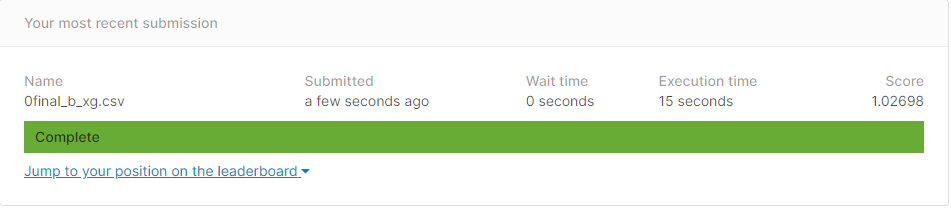

In [ ]:
score_from_kaggle = 1.02698
scores = [tr_loss_mse, val_loss_mse, score_from_kaggle]
Add_Score_to_result_table(scores_table, 'B : ML algorithm XGB', scores)

,0,B : ML algorithm XGB
0,train_score,1.690591
1,val_score,1.660086
2,test_score,1.026980


### ML Algorithm : Random Forest Regressor

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=5, max_depth = 3, n_jobs = -1, criterion='mse')
temp_df = tr_data[['s_enc','i_enc', 'day_of_month', 'day_of_week', 'month', 'year']]
rf_reg.fit(temp_df, tr_data.unit_sales)
tr_preds = rf_reg.predict(temp_df)
tr_loss_mse = NWRMSLE(tr_data.unit_sales, tr_preds, [1]*len(tr_data))
print('2017_train_loss:'+str(tr_loss_mse))
temp_df = val_data[['s_enc','i_enc', 'day_of_month', 'day_of_week', 'month', 'year']]
val_preds = rf_reg.predict(temp_df)
val_loss_mse = NWRMSLE(val_data.unit_sales, val_preds, [1]*len(val_data))
print('2017_val_loss:'+str(val_loss_mse))

2017_train_loss:1.222700521499767
2017_val_loss:1.2111915960071307


In [ ]:
rf_tst_preds = ML_algorithm_predict(test_data, rf_reg)
rf_tst_preds_kaggle = create_csv_to_kaggle(path+'0final_b_rf.csv', rf_tst_preds)

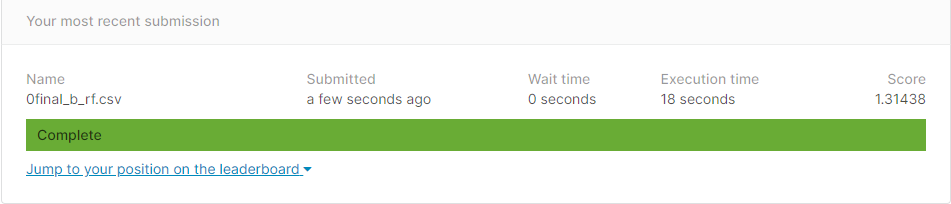

In [ ]:
score_from_kaggle = 1.31438
scores = [tr_loss_mse, val_loss_mse, score_from_kaggle]
Add_Score_to_result_table(scores_table, 'B : ML algorithm Random Forest', scores)

,0,B : ML algorithm XGB,B : ML algorithm Random Forest
0,train_score,1.690591,1.222701
1,val_score,1.660086,1.211192
2,test_score,1.026980,1.314380


## c. creating embedding model : 
preprocess, features as embedding input, build model

Fit & Predict with Store, Item and Date Features

In [36]:
def set_callbacks(description='run1',patience=15,tb_base_logdir='./logs/'):
    cp = ModelCheckpoint(path + 'best_model_weights_{}.h5'.format(description),save_best_only=True)
    es = EarlyStopping(patience=patience,monitor='val_loss')
    rlop = ReduceLROnPlateau(patience=5)   
    tb = TensorBoard(log_dir='{}{}'.format(tb_base_logdir,description))
#     cycl = CyclicLR(max_lr=0.03,step_size=5000)
    cb = [cp,es,tb,rlop]
    return cb

In [37]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [38]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [39]:
def plt_model(model_hist):
        loss = model_hist.history['loss']
        val_loss = model_hist.history['val_loss']

        epochs = range(1, len(loss) + 1)

        #plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, color='#eb4d4b', marker='o', linestyle='none', label='Training Loss')
        plt.plot(epochs, val_loss, color='#eb4d4b', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.legend(loc='best')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        plt.show()

Create embedding input layer for each feature - No bias 

In [ ]:
store_in, s = embedding_input('store_in', n_stores, round(math.sqrt(n_stores)), 1e-4)
items_in, i = embedding_input('items_in', n_items, round(math.sqrt(n_items)), 1e-4)
day_of_month_in, dom = embedding_input('day_of_month_in', n_days_of_month, round(math.sqrt(n_days_of_month)), 1e-4)
day_of_week_in, dow = embedding_input('day_of_week_in', n_days_of_week, round(math.sqrt(n_days_of_week)), 1e-4)
month_in, m = embedding_input('month_in', n_months, round(math.sqrt(n_months)), 1e-4)
year_in, y = embedding_input('year_in', n_years, round(math.sqrt(n_years)), 1e-4)
x = concatenate([s, i, dom, dow, m, y])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(8, activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(1)(x)
nn = Model([store_in, items_in,day_of_month_in, day_of_week_in,month_in,year_in], x)
nn.compile(Adam(0.001), loss='mse')
nn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
items_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
day_of_month_in (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
day_of_week_in (InputLayer)     [(None, 1)]          0                                            
______________________________________________________________________________________________

Create embedding input layer and bias for each feature - with Bias

In [ ]:
store_in, s = embedding_input('store_in', n_stores, round(math.sqrt(n_stores)), 1e-4)
store_b = create_bias(store_in, n_stores)
items_in, i = embedding_input('items_in', n_items, round(math.sqrt(n_items)), 1e-4)
items_b = create_bias(items_in, n_items)
day_of_month_in, dom = embedding_input('day_of_month_in', n_days_of_month, round(math.sqrt(n_days_of_month)), 1e-4)
day_of_month_b = create_bias(day_of_month_in, n_days_of_month)
day_of_week_in, dow = embedding_input('day_of_week_in', n_days_of_week, round(math.sqrt(n_days_of_week)), 1e-4)
day_of_week_b = create_bias(day_of_week_in, n_days_of_week)
month_in, m = embedding_input('month_in', n_months, round(math.sqrt(n_months)), 1e-4)
month_b = create_bias(month_in, n_months)
year_in, y = embedding_input('year_in', n_years, round(math.sqrt(n_years)), 1e-4)
year_b = create_bias(year_in, n_years)
x = concatenate([s, i, dom, dow, m, y])
x = Flatten()(x)
x = add([x, store_b])
x = add([x, items_b])
x = add([x, day_of_month_b])
x = add([x, day_of_week_b])
x = add([x, month_b])
x = add([x, year_b])
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(8, activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(1)(x)
nn_bias = Model([store_in, items_in,day_of_month_in, day_of_week_in,month_in,year_in], x)
nn_bias.compile(Adam(0.001), loss='mse')
nn_bias.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
items_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
day_of_month_in (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
day_of_week_in (InputLayer)     [(None, 1)]          0                                            
____________________________________________________________________________________________

## d. Predict using features embedding

without bias:

In [ ]:
print('year 2017:') 
history = nn.fit([tr_data.s_enc, tr_data.i_enc, tr_data.day_of_month, tr_data.day_of_week, tr_data.month, tr_data.year], tr_data.unit_sales, batch_size=64, epochs=5, 
           validation_data=([val_data.s_enc, val_data.i_enc, val_data.day_of_month, val_data.day_of_week, val_data.month, val_data.year], val_data.unit_sales), callbacks = set_callbacks(description='d_nn'))

year 2017:
Epoch 1/5
347458/347458 [==============================] - 1168s 3ms/step - loss: 1.2822 - val_loss: 0.9844
Epoch 2/5
347458/347458 [==============================] - 1150s 3ms/step - loss: 1.2040 - val_loss: 1.0035
Epoch 3/5
347458/347458 [==============================] - 1149s 3ms/step - loss: 1.2021 - val_loss: 1.0145
Epoch 4/5
347458/347458 [==============================] - 1148s 3ms/step - loss: 1.2016 - val_loss: 1.0137
Epoch 5/5
347458/347458 [==============================] - 1152s 3ms/step - loss: 1.2004 - val_loss: 1.0218


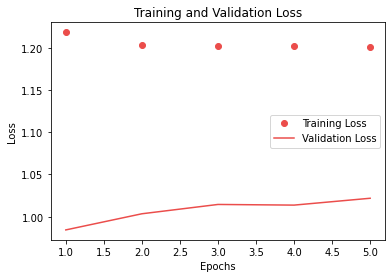

In [ ]:
tr_loss_mse = history.history['loss'][-1]
val_loss_mse = history.history['val_loss'][-1]
plt_model(history)

In [ ]:
nn.load_weights(path + 'best_model_weights_{}.h5'.format('d_nn'))
preds = nn.predict([test_data.s_enc, test_data.i_enc, test_data.day_of_month, test_data.day_of_week, test_data.month, test_data.year])
nn_kaggle_preds = create_csv_to_kaggle(path+'0final_d_nn.csv', preds)

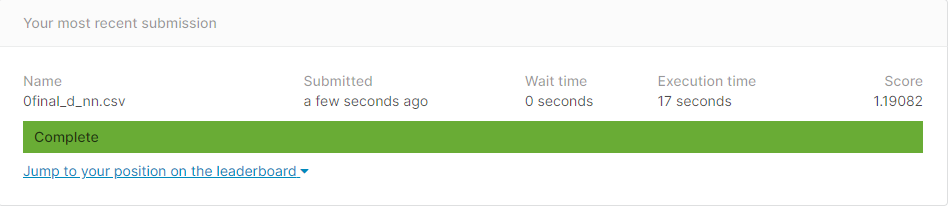

In [ ]:
score_from_kaggle = 1.19082
scores = [tr_loss_mse, val_loss_mse, score_from_kaggle]
Add_Score_to_result_table(scores_table, 'D : Embedding NN No Bias', scores)

,0,B : ML algorithm XGB,B : ML algorithm Random Forest,D : Embedding NN No Bias
0,train_score,1.690591,1.222701,1.201341
1,val_score,1.660086,1.211192,1.021849
2,test_score,1.026980,1.314380,1.190820


with bias:

In [ ]:
print('year 2017:') 
history = nn_bias.fit([tr_data.s_enc, tr_data.i_enc, tr_data.day_of_month, tr_data.day_of_week, tr_data.month, tr_data.year], tr_data.unit_sales, batch_size=64, epochs=5, 
           validation_data=([val_data.s_enc, val_data.i_enc, val_data.day_of_month, val_data.day_of_week, val_data.month, val_data.year], val_data.unit_sales), callbacks = set_callbacks(description='d_nn_bias'))

year 2017:
Epoch 1/5
347458/347458 [==============================] - 1487s 4ms/step - loss: 1.2339 - val_loss: 0.9588
Epoch 2/5
347458/347458 [==============================] - 1344s 4ms/step - loss: 1.1514 - val_loss: 0.9935
Epoch 3/5
347458/347458 [==============================] - 1288s 4ms/step - loss: 1.1506 - val_loss: 0.9259
Epoch 4/5
347458/347458 [==============================] - 1292s 4ms/step - loss: 1.1514 - val_loss: 0.9593
Epoch 5/5
347458/347458 [==============================] - 1289s 4ms/step - loss: 1.1515 - val_loss: 1.0131


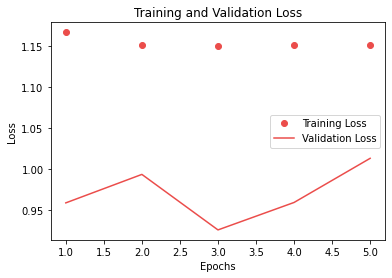

In [ ]:
tr_loss_mse = history.history['loss'][-1]
val_loss_mse = history.history['val_loss'][-1]
plt_model(history)

In [ ]:
nn_bias.load_weights(path + 'best_model_weights_{}.h5'.format('d_nn_bias'))
preds = nn_bias.predict([test_data.s_enc, test_data.i_enc, test_data.day_of_month, test_data.day_of_week, test_data.month, test_data.year])
nn_kaggle_preds = create_csv_to_kaggle(path+'0final_d_nn_bias.csv', preds)

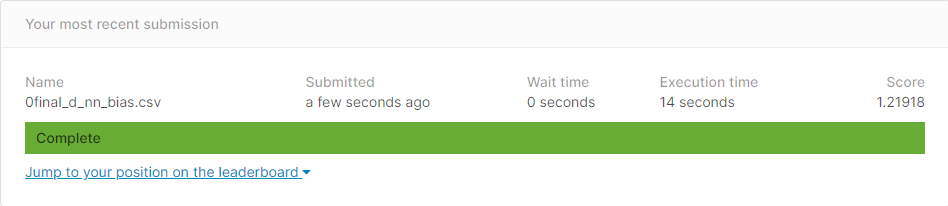

In [ ]:
score_from_kaggle = 1.21918
scores = [tr_loss_mse, val_loss_mse, score_from_kaggle]
Add_Score_to_result_table(scores_table, 'D : Embedding NN Bias', scores)

,0,B : ML algorithm XGB,B : ML algorithm Random Forest,D : Embedding NN No Bias,D : Embedding NN Bias
0,train_score,1.690591,1.222701,1.201341,1.151640
1,val_score,1.660086,1.211192,1.021849,1.013128
2,test_score,1.026980,1.314380,1.190820,1.219180


## e. Adding more features to the model:
adding fetures from other tables
merge the tables with train and test *data*

In [42]:
df_stores = import_data(path + 'stores.csv')

100%|██████████| 5/5 [00:00<00:00, 1028.82it/s]


In [43]:
train_data = train_data.merge(df_stores, how='inner', on='store_nbr')
train_data = reduce_mem_usage(train_data)

100%|██████████| 16/16 [00:02<00:00,  7.37it/s]


In [44]:
test_data = test_data.merge(df_stores, how='inner', on='store_nbr')
test_data = reduce_mem_usage(test_data)

100%|██████████| 15/15 [00:00<00:00, 70.22it/s]


In [45]:
del df_stores; gc.collect()

12

In [46]:
df_items = import_data(path + 'items.csv')

100%|██████████| 4/4 [00:00<00:00, 745.42it/s]


In [47]:
train_data = train_data.merge(df_items, how='inner', on='item_nbr')
train_data = reduce_mem_usage(train_data)

100%|██████████| 19/19 [00:02<00:00,  8.20it/s]


In [48]:
test_data = test_data.merge(df_items, how='inner', on='item_nbr')
test_data = reduce_mem_usage(test_data)

100%|██████████| 18/18 [00:00<00:00, 77.03it/s]


In [49]:
del df_items; gc.collect()


0

Feature encoding

In [50]:
train_data['family'] = [family_enc[x] for x in train_data['family']]
train_data = reduce_mem_usage(train_data)
train_data['class'] = [class_enc[x] for x in train_data['class']]
train_data = reduce_mem_usage(train_data)
train_data['perishable'] = [perishable_enc[x] for x in train_data['perishable']]
train_data = reduce_mem_usage(train_data)
train_data['city'] = [city_enc[x] for x in train_data['city']]
train_data = reduce_mem_usage(train_data)
train_data['state'] = [state_enc[x] for x in train_data['state']]
train_data = reduce_mem_usage(train_data)
train_data['type'] = [type_enc[x] for x in train_data['type']]
train_data = reduce_mem_usage(train_data)
train_data['cluster'] = [cluster_enc[x] for x in train_data['cluster']]
train_data = reduce_mem_usage(train_data)

100%|██████████| 19/19 [00:02<00:00,  7.59it/s]


In [51]:
test_data['family'] = [family_enc[x] for x in test_data['family']]
test_data = reduce_mem_usage(test_data)
test_data['class'] = [class_enc[x] for x in test_data['class']]
test_data = reduce_mem_usage(test_data)
test_data['perishable'] = [perishable_enc[x] for x in test_data['perishable']]
test_data = reduce_mem_usage(test_data)
test_data['city'] = [city_enc[x] for x in test_data['city']]
test_data = reduce_mem_usage(test_data)
test_data['state'] = [state_enc[x] for x in test_data['state']]
test_data = reduce_mem_usage(test_data)
test_data['type'] = [type_enc[x] for x in test_data['type']]
test_data = reduce_mem_usage(test_data)
test_data['cluster'] = [cluster_enc[x] for x in test_data['cluster']]
test_data = reduce_mem_usage(test_data)

100%|██████████| 18/18 [00:00<00:00, 63.70it/s]


Feature selection :
to select the best features for our model we used random forest to understand better how much each feature contributed to the prediction

In [ ]:
selected_cols = ['day_of_month', 'day_of_week', 'month', 'year', 'onpromotion', 'family', 'class', 'perishable', 'city', 'state', 'type', 'cluster']
x_train = train_data[selected_cols]
y_train = train_data['unit_sales']
fs_rf = RandomForestRegressor(n_estimators = 5)
sel = SelectFromModel(fs_rf,threshold=0.05)
print("start fit")
sel.fit(x_train, y_train)
selected_feat= x_train.columns[(sel.get_support())]
sel_tran = sel.transform(x_train)
print("The selected features are:")
print(selected_feat)

start fit
The selected features are:
Index(['day_of_month', 'day_of_week', 'month', 'family', 'class', 'type',
       'cluster'],
      dtype='object')


Drop the features that not selected

In [52]:
train_data.drop(columns=[ 'year', 'onpromotion', 'perishable', 'city', 'state'], inplace=True)

In [53]:
test_data.drop(columns=[ 'year', 'onpromotion', 'perishable', 'city', 'state'], inplace=True)

In [54]:
n_family = len(family_enc)
n_class = len(class_enc)
n_type = len(type_enc)
n_cluster = len(cluster_enc)

In [55]:
tr_data = train_data.query('month < 7')
val_data = train_data.query('month == 7')
len(tr_data), len(val_data)

(22237293, 1570968)

Fit & Predict with features from feature selection : Category embedding


In [56]:
store_in, s = embedding_input('store_in', n_stores, round(math.sqrt(n_stores)), 1e-4)
items_in, i = embedding_input('items_in', n_items, round(math.sqrt(n_items)), 1e-4)
day_of_month_in, dom = embedding_input('day_of_month_in', n_days_of_month, round(math.sqrt(n_days_of_month)), 1e-4)
day_of_week_in, dow = embedding_input('day_of_week_in', n_days_of_week, round(math.sqrt(n_days_of_week)), 1e-4)
month_in, m = embedding_input('month_in', n_months, round(math.sqrt(n_months)), 1e-4)
family_in, f = embedding_input('family_in', n_family, round(math.sqrt(n_family)), 1e-4)
class_in, cla = embedding_input('class_in', n_class, round(math.sqrt(n_class)), 1e-4)
type_in, t = embedding_input('type_in', n_type, round(math.sqrt(n_type)), 1e-4)
cluster_in, clu = embedding_input('cluster_in', n_cluster, round(math.sqrt(n_cluster)), 1e-4)
x = concatenate([s, i, dom, dow, m, f, cla, t, clu])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(8, activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(1)(x)
nn = Model([ store_in, items_in, day_of_month_in, day_of_week_in, month_in, family_in, class_in, type_in, cluster_in], x)
nn.compile(Adam(0.001), loss='mse')
nn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
items_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
day_of_month_in (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
day_of_week_in (InputLayer)     [(None, 1)]          0                                            
______________________________________________________________________________________________

In [61]:
history = nn.fit([tr_data.s_enc, tr_data.i_enc, tr_data.day_of_month, tr_data.day_of_week, tr_data.month, tr_data.family, tr_data['class'], tr_data['type'], tr_data.cluster], tr_data.unit_sales, batch_size=64, epochs=5, 
           validation_data=([val_data.s_enc, val_data.i_enc, val_data.day_of_month, val_data.day_of_week, val_data.month, val_data.family, val_data['class'], val_data['type'], val_data.cluster], val_data.unit_sales), callbacks = set_callbacks(description='e_nn'))

Epoch 1/5
347458/347458 [==============================] - 1512s 4ms/step - loss: 1.2194 - val_loss: 0.9374
Epoch 2/5
347458/347458 [==============================] - 1486s 4ms/step - loss: 1.1575 - val_loss: 0.9620
Epoch 3/5
347458/347458 [==============================] - 1476s 4ms/step - loss: 1.1562 - val_loss: 0.9551
Epoch 4/5
347458/347458 [==============================] - 1549s 4ms/step - loss: 1.1546 - val_loss: 0.9326
Epoch 5/5
347458/347458 [==============================] - 1522s 4ms/step - loss: 1.1548 - val_loss: 0.9558


In [62]:
tr_loss_mse = history.history['loss'][-1]
val_loss_mse = history.history['val_loss'][-1]

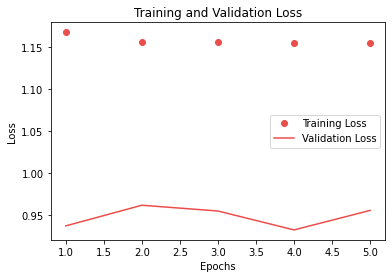

In [63]:
plt_model(history)

In [64]:
nn.load_weights(path + 'best_model_weights_{}.h5'.format('e_nn'))
preds = nn.predict([test_data.s_enc, test_data.i_enc, test_data.day_of_month, test_data.day_of_week, test_data.month, test_data.family, test_data['class'], test_data['type'], test_data.cluster])
nn_kaggle_preds = create_csv_to_kaggle(path+'0final_e_nn.csv', preds)

In [88]:
score_from_kaggle = 1.18640
scores = [tr_loss_mse, val_loss_mse, score_from_kaggle]
Add_Score_to_result_table(scores_table, 'E : Category Embedding NN', scores)

,0,B : ML algorithm XGB,B : ML algorithm Random Forest,D : Embedding NN No Bias,D : Embedding NN Bias,E : Category Embedding NN
0,train_score,1.690591,1.222701,1.201341,1.151640,1.154801
1,val_score,1.660086,1.211192,1.021849,1.013128,0.955837
2,test_score,1.026980,1.314380,1.190820,1.219180,1.186400


## f. Insights

when create an Embedding layer we found that the best value for the argument n_out is square root of n_in.

we found out the the n_in argument cant be consistant and depend on the number of unique values of each feature.

when using category embedding each feature represented as vector hence the new  representation need more data so features need to be selected carfully.

we didnt Succeeded to improve the result with bias, maybe it because the model wasnt enough complex or maybe it was needed more epoches


## g. Feature extractor

In [58]:
gc.collect()
nn.load_weights(path + 'best_model_weights_{}.h5'.format('e_nn'))
nn_no_last_layer= Model(nn.input, nn.layers[-2].output)
nn_no_last_layer.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
items_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
day_of_month_in (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
day_of_week_in (InputLayer)     [(None, 1)]          0                                            
____________________________________________________________________________________________

embedding model Predict without last layer : Feature extractor

In [59]:
tr_preds =nn_no_last_layer.predict([tr_data.s_enc, tr_data.i_enc, tr_data.day_of_month, tr_data.day_of_week, tr_data.month, tr_data.family, tr_data['class'], tr_data['type'], tr_data.cluster])
val_preds = nn_no_last_layer.predict([val_data.s_enc, val_data.i_enc, val_data.day_of_month, val_data.day_of_week, val_data.month, val_data.family, val_data['class'], val_data['type'], val_data.cluster])
test_preds = nn_no_last_layer.predict([test_data.s_enc, test_data.i_enc, test_data.day_of_month, test_data.day_of_week, test_data.month, test_data.family, test_data['class'], test_data['type'], test_data.cluster])

Predict with XGB Regressor

In [60]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 3, alpha = 10, n_estimators = 3)
xg_reg.fit(tr_preds, tr_data.unit_sales)

[07:14:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:14:10] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=3,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [61]:
tr_preds_xg = xg_reg.predict(tr_preds)
tr_loss_mse = NWRMSLE(tr_data.unit_sales, tr_preds_xg, [1]*len(tr_data))
print('2017_train_loss:'+str(tr_loss_mse))

2017_train_loss:1.8018155970001348


In [62]:
val_preds_xg = xg_reg.predict(val_preds)
val_loss_mse = NWRMSLE(val_data.unit_sales, val_preds_xg, [1]*len(val_data))
print('2017_val_loss:'+str(val_loss_mse))

2017_val_loss:1.7685269926179505


In [63]:
test_preds_xg = xg_reg.predict(test_preds)
nn_no_last_layer_kaggle_preds = create_csv_to_kaggle(path+'0final_g_xg.csv', test_preds_xg)

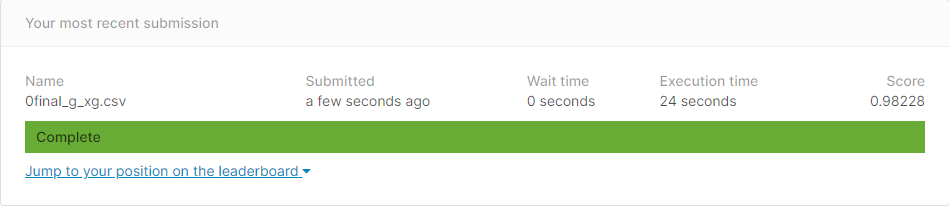

In [89]:
score_from_kaggle = 0.98228
scores = [tr_loss_mse, val_loss_mse, score_from_kaggle]
Add_Score_to_result_table(scores_table, 'G : Feature extractor XGB', scores)

,0,B : ML algorithm XGB,B : ML algorithm Random Forest,D : Embedding NN No Bias,D : Embedding NN Bias,E : Category Embedding NN,G : Feature extractor XGB
0,train_score,1.690591,1.222701,1.201341,1.151640,1.154801,1.801816
1,val_score,1.660086,1.211192,1.021849,1.013128,0.955837,1.768527
2,test_score,1.026980,1.314380,1.190820,1.219180,1.186400,0.982280


Predict with Random Forest

In [65]:
rf_reg = RandomForestRegressor(n_estimators=5, max_depth = 3, n_jobs = -1, criterion='mse')
rf_reg.fit(tr_preds, tr_data.unit_sales)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [66]:
tr_preds_rf = rf_reg.predict(tr_preds)
tr_loss_mse = NWRMSLE(tr_data.unit_sales, tr_preds_rf, [1]*len(tr_data))
print('2017_train_loss:'+str(tr_loss_mse))

2017_train_loss:0.8815291346546199


In [67]:
val_preds_rf = rf_reg.predict(val_preds)
val_loss_mse = NWRMSLE(val_data.unit_sales, val_preds_rf, [1]*len(val_data))
print('2017_val_loss:'+str(val_loss_mse))

2017_val_loss:0.8928055367273302


In [68]:
test_preds_rf = rf_reg.predict(test_preds)
nn_no_last_layer_kaggle_preds = create_csv_to_kaggle(path+'0final_g_rf.csv', test_preds_rf)

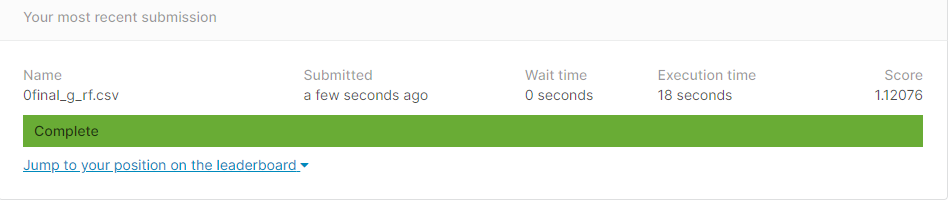

In [90]:
score_from_kaggle = 1.12076
scores = [tr_loss_mse, val_loss_mse, score_from_kaggle]
Add_Score_to_result_table(scores_table, 'G : Feature extractor Random Forest', scores)

,0,B : ML algorithm XGB,B : ML algorithm Random Forest,D : Embedding NN No Bias,D : Embedding NN Bias,E : Category Embedding NN,G : Feature extractor XGB,G : Feature extractor Random Forest
0,train_score,1.690591,1.222701,1.201341,1.151640,1.154801,1.801816,0.881529
1,val_score,1.660086,1.211192,1.021849,1.013128,0.955837,1.768527,0.892806
2,test_score,1.026980,1.314380,1.190820,1.219180,1.186400,0.982280,1.120760


in section b we get a solid benchmark of loss = 1.026980 using XGB and loss = 1.314380 using Random Forest. Easy to see that the XGB return good result, but the train and val loss are not reflects the test score. features - store, item and date features.

in section d we get test score of loss = 1.190820 nn model when we using same features in section b as embedding layers. we tried to improve our results with adding biases to each layer, but it doesn't improve it.

in section e we get score of loss = 1.186400, a little improvement of our last section. we selected the best features to the model by feature selection using random forest, and used this features as embedding layer as well. features - store, item, date features, family and class( item features), type and cluster( store features).

in section g we cross our benchmark from section b and get score of loss = 0.982280	using XGB, and loss = 1.120760. we used our model in section e as feature extractor to ML algorithm.
